In [1]:
import numpy as np
from numpy.polynomial.legendre import leggauss
import matplotlib.pyplot as plt
from scipy.interpolate import krogh_interpolate, KroghInterpolator
from collections import namedtuple

# An element is just a tuple of two elements: its left boundary (called a)
# and its right boundary (called b). I created a namedtuple so that is
# easier to recongize that the tuple that we are working with represent
# an element and not something else
Element = namedtuple('Element', ['a', 'b'])

# This is the "reference element" that contains a lot of information.
# In particular, it has the boundaries (a and b), the position of the
# lagrangian nodes (dofs), the position of the quadrature points
# (q_points), the quadrature weights (q_weights) and the most
# complicated object that contains the evaluation of the basis
# functions on the quadrature points. Indeed, basis_functions is a
# three dimensional numpy array. basis_functions[0, i, j] is the
# evaluation of the i-th lagrangian polynomial on the j-th quadrature
# point. basis_functions[1, i, j], instead, is the evaluation of the
# derivative of the i-th lagrangian polynomial on the j-th quadrature
# points. Our code does not require the second derivatives of the basis
# functions but, in that case, we would have allocated another index
# like basis_functions[2, :, :].
ReferenceElement = namedtuple(
    'ReferenceElement',
    ['a', 'b', 'dofs', 'q_points', 'q_weights', 'basis_functions']
)

# This is the result obtained by numbering the degrees of freedom (DOFs).
# Indeed, it contains the total number of dofs inside our domain (n_of_dofs),
# the number of lagrangian nodes for each cell (dofs_per_element) and 
# element_dofs, a map that associates to each Element a vector v so that the
# i-th basis function of the current Element is the v[i]-th degree of freedom
# of our system (i.e., if you want to know where to put into the global matrix
# the element [i, j] of the local one, it must be put in [v[i], v[j]])
DofMap = namedtuple(
    'DofMap',
    ['n_of_dofs', 'dofs_per_element', 'element_dofs']
)

In [2]:
def generate_domain(x0, x1, points):
    """
    Return the domain for our problem. For us, the domain is an interval that
    is split into several elements. For Python, instead, the domain is just a
    list of Elements
    
    Args:
        x0: the left boundary of the domain
        x1: the right boundary of the domain
        points: A list or an array of points that are between x0 and x1; these
                are the points where one Element ends and another begins. For
                example, if points is the list [0.2, 0.7] and x0 is 0 and x1 is
                1, then our domain will be made of 3 Elements: one from 0 to
                0.2, one from 0.2 to 0.7 and the last from 0.7 to 1. If this
                list is empty, then only one Element will be created. The list
                is expected to be sorted (from the smallest to the biggest).
    
    Returns:
        A list of Elements. The list is ordered from the left to the right
    """
    
    # Check that all the points are inside the domain
    for p in points:
        if p <= x0 or p >= x1:
            raise ValueError('Point {} is outside interval'.format(p))
    
    # Check that the points are sorted
    for i in range(len(points) -1):
        if points[i] >= points[i + 1]:
            raise ValueError(
                'Points vector is not ordered or there are two identical points'
            )
    
    # Build the first and the last element. Of course, if we have no points,
    # then the last is also the first (because there is only one element)
    if len(points) > 0:
        first_element = Element(x0, points[0])
        last_element = Element(points[-1], x1)
    else:
        first_element = Element(x0, x1)

    # This is the list that we will return. We already inserted the first
    # element inside it
    elements = [first_element]

    # Now we build each element (beside the first and the last) 
    for i in range(len(points) - 1):
        element = Element(points[i], points[i + 1])
        elements.append(element)
    
    # If the last element is different from the first one, we add it
    # to the list
    if len(points) > 0:
        elements.append(last_element)
    return elements

In [3]:
def generate_reference_element(degree):
    """
    Generate a ReferenceElement for our method
    
    Args:
        degree: The degree of the lagrangian polynomials that you
                will use
    
    Returns:
        A ReferenceElement
    """
    
    # The number of lagrangian nodes on each element
    dofs_per_element = degree + 1
    
    # How many quadrature points are we going tu use? If we use
    # (as it may seem reasonable) a gaussian formula on each element,
    # then this is the smallest number of quadrature points so that
    # the quadrature rule is exact (if f and sigma are constants).
    # Indeed, when we multiply two basis fuctions (as we do in our
    # problem), we get a polynomial of degree 2d (where d is the 
    # degree of our lagrangian polynomials). We know that a gaussian
    # formula with q points can integrate exactly all polynomials up
    # to degree 2q - 1 and, therefore, if we use (d + 1) points we
    # will be able to integrate until degree
    # 2(d + 1) - 1 = 2d + 1
    # This means that, with this choice, we are able to integrate
    # exactly our polynomials and, in principle, even one degree more
    # (so, if sigma is a linear function, we are ok!)
    # Of course, if sigma is not a polynomial, then there is no way to
    # choose a number of quadrature points so that the integration is
    # always exact ("life is difficult!").
    # So this number is a compromise that you are free to modify: if you
    # feel that f and sigma are funtions that are hard to integrate, you
    # can increase this number, but you will slow down a little bit all
    # the code.
    n_q_points = degree + 1
    
    # Here I compute the quadrature points and the weights using the
    # leggauss function that I have imported from numpy before.
    # Because this formula works for the interval [-1, 1] and my reference
    # element will be on [0, 1] (I decided so, but it is not mandatory), I
    # have to rescale both the weights and the nodes
    q_points, q_weights = leggauss(n_q_points)
    
    q_points += 1.
    q_points /= 2.
    
    q_weights /= 2.
    
    # These are the nodes for the lagrangian interpolation. I am taking them
    # equally spaced with the first one on the left boundary and the last one
    # on the right. You can move them, but if you move the nodes away from the
    # boundaries then is not so easy to enforce continuity on your global
    # functions
    dofs = np.linspace(0, 1, dofs_per_element)
    
    # This is the space that I have allocated to save, for each basis function,
    # its evaluation on the quadrature points (and the evaluation of its
    # derivative).
    basis_functions = np.empty(
        (2, dofs_per_element, n_q_points),
        dtype=np.float64
    )
    
    # This is the values that the current basis function assumes on each node
    # For now they are all zero
    values_on_dofs = np.zeros((dofs_per_element,), dtype=np.float64)

    # For each lagrangian polynomial
    for i in range(dofs_per_element):
        # First of all, I set 1 on the i-th element of this vector. In this way,
        # it contains exactly the values that my lagrangian polynomial produces
        # when evaluated on the lagrangian nodes (always 0 beside on its own
        # node, where is 1)
        values_on_dofs[i] = 1

        # Because I am lazy (and I do not want to reivent the wheel) I am using
        # scipy to perform a polynomial interpolation. In particular, I am
        # asking scipy to find the only polynomial of degree "degree" that on
        # the lagrangian nodes ("dofs") is always 0 beside on the i-th node
        # where is 1 ("value_on_dofs"). When this polynomial has been found (and
        # we now that is the i-th lagrangian polynomial), we want to retrieve
        # its evaluations on the quadrature points ("q_points"). Then, I store
        # all these evaluations inside the vector basis_funtctions[0, i]; in
        # other words, basis_functions[0, i] is a vector that contains the
        # evaluation of the i-th lagrangian polynomial on the quadrature
        # points
        basis_functions[0, i, :] = krogh_interpolate(
            dofs,
            values_on_dofs,
            q_points
        )
        
        # The same than before, but now we do not want the evaluation of the
        # polynomial but the evaluation of its derivative
        basis_functions[1, i, :] = krogh_interpolate(
            dofs,
            values_on_dofs,
            q_points,
            der=1
        )

        # Before going on with the next polynomial, I clean values_on_dofs so
        # it is ready for later
        values_on_dofs[i] = 0

    # and here I build the reference element that I will return
    reference_element = ReferenceElement(
        a=0,
        b=1,
        dofs=dofs,
        q_points=q_points,
        q_weights=q_weights,
        basis_functions=basis_functions
    )
    return reference_element


def get_quadrature_points(element, reference_element):
    """
    Compute the position of the quadrature points for the element
    moving the quadrature points that have been stored for the
    reference element
    
    Args:
        element: an element
        reference_element: the reference element for your method

    Returns:
        A numpy array with the position of the quadrature points for
        the element
    """
    a = element.a
    b = element.b
    return reference_element.q_points * (b - a) + a


def get_quadrature_weights(element, reference_element):
    """
    Compute the quadrature weights for the quadrature rule of the
    element moving the quadrature points that have been stored for
    the reference element
    
    Args:
        element: an element
        reference_element: the reference element for your method

    Returns:
        A numpy array with the quadrature weights for the element
    """
    return reference_element.q_weights * (element.b - element.a)


def get_basis_function_values(element, reference_element):
    """
    Compute the values of the lagrangian polynomials on the
    quadrature points of the current element moving the evaluations
    that have been stored for the reference element
    
    Args:
        element: an element
        reference_element: the reference element for your method

    Returns:
        A read-only numpy array with the evaluation of the basis
        functions on the quadrature points of the element
    """
    f_values = reference_element.basis_functions[0, :, :]
    
    # Watch out for this problem! In principle, this should be the easiest
    # function to write because we need to return some values that we have
    # already stored without any computation. The problem is that, if we
    # return the previous array and somebody modifies it (for example,
    # filling it with zeros) then it will also modify the content of the
    # reference element. For this reason, we set this flag on the array to
    # prevent this possibility!
    f_values.flags.writeable = False
    return f_values


def get_basis_function_derivatives(element, reference_element):
    """
    Compute the derivatives of the lagrangian polynomials on the
    quadrature points of the current element moving the evaluations
    that have been stored for the reference element
    
    Args:
        element: an element
        reference_element: the reference element for your method

    Returns:
        A numpy array with the derivatives of the basis functions
        on the quadrature points of the element
    """
    cell_size = (element.b - element.a)
    return reference_element.basis_functions[1, :, :] / cell_size

In [4]:
def map_dofs(domain, reference_element):
    """
    Number the degree of freedom of the system.
    
    Args:
        domain: an ordered list of Elements
        reference_element: the ReferenceElement of your method
    
    Returns:
        A DofMap
    """
    # The number of lagrangian nodes on each cell can be
    # obtained from the size of the array that contains
    # their position
    dofs_per_element = reference_element.dofs.shape[0]

    # Current dof is the number of the global degree of
    # freedom we are examining. Every time we meet another
    # dof, we increase this number
    current_dof = 0

    # This is the map that associates to each cell a list of
    # indices v such that v[i] is the global index of the
    # lagrangian node i of this element
    element_dofs = {}

    # For each element
    for element in domain:
        
        # We perpare the list
        current_element_dofs = []

        # For each node of the current element
        for local_dof in range(dofs_per_element):
            # We add the current global index to the list
            current_element_dofs.append(current_dof)
            # We increase the counter of the global dofs
            current_dof += 1

        # The vector is ready. We add it to the map
        element_dofs[element] = current_element_dofs
        
        # We decrease the index of the global dofs by one because,
        # in this way, when we meet again the same node as the first
        # one of the next element, we will use the same index
        current_dof -= 1

    # This fixes the previous -1 that should not have been performed
    # on the last element
    n_of_dofs = current_dof + 1

    return DofMap(n_of_dofs, dofs_per_element, element_dofs)


In [5]:
def assemble_system_on_one_element(element, reference_element, f, sigma):
    """
    Build the local matrix and the local right hand side vector for a specific
    Element
    
    Args:
        element: the Element the matrix must be assembled for
        reference_element: the ReferenceElement of your method
        f: the function f as a numpy callable function
        sigma: the function sigma as a numpy callable function
    
    Returns:
        The local matrix and the local right hand side vector for the element
    """
    
    dofs_per_element = reference_element.dofs.shape[0]
    
    # Allocate space for the local matrix and for the local right hand side
    # vector
    m = np.zeros((dofs_per_element, dofs_per_element), dtype=np.float64)
    rhs = np.zeros((dofs_per_element,), dtype=np.float64)
    
    # Compute the qudrature rule for the current element
    q_points = get_quadrature_points(element, reference_element)
    q_weights = get_quadrature_weights(element, reference_element)
    
    n_q_points = q_points.shape[0]
    
    # Get the values of the basis functions on the quadrature points;
    # basis_values is a 2d array such that basis_values[i, q] is the value
    # of the i-th basis function on the q-th quadrature point
    b_values = get_basis_function_values(element, reference_element)
    b_derivatives = get_basis_function_derivatives(
        element,
        reference_element
    )

    # Evaluate f on each quadrature point
    f_eval= f(q_points)
    
    # The same for sigma
    sigma_eval = sigma(q_points)
    
    # The following loop can (and should) be vectorized using numpy! But I
    # decided to write it in this way to ensure that it is totally clear what
    # is going on.
    #   * i is the index of the test function (the row of the matrix)
    #   * j is the index of the basis function we are testing (the column of
    #     the matrix)
    #   * q is the index of the quadrature points
    for i in range(dofs_per_element):
        for j in range(dofs_per_element):
            for q in range(n_q_points):
                JxW = q_weights[q]
                m[i, j] += b_derivatives[i, q] * b_derivatives[j, q] * JxW
                m[i, j] += sigma_eval[q] * b_values[i, q] * b_values[j, q] * JxW

    # Here we are doing exactly the same for the right hand side. Of course,
    # in this case we need only two loops (and not three)
    for i in range(dofs_per_element):
        for q in range(q_points.shape[0]):
            JxW = q_weights[q]
            rhs[i] += b_values[i, q] * f_eval[q] * JxW

    # We return the local matrix and the local rhs
    return m, rhs


def distribute_matrix_local_to_global(local_matrix, global_m, element_dofs):
    """
    Add the elements of a local matrix to the global one
    
    Args:
        local_matrix: the local matrix of an element
        global_matrix: the global matrix of the method
        element_dofs: a list of indices so that the element i, j of the
                      local matrix will be added to the entry
                      element_dofs[i], element_dofs[j] of the global one
    """
    dofs_per_element = len(element_dofs)
    for i in range(dofs_per_element):
        ii = element_dofs[i]
        for j in range(dofs_per_element):
            jj = element_dofs[j]
            global_m[ii, jj] += local_matrix[i, j]

            
def distribute_rhs_local_to_global(local_rhs, global_rhs, element_dofs):
    """
    Add the elements of a local right hand side vector to the global one
    
    Args:
        local_rhs: the local right hand side vector of an element
        global_rhs: the global right hand side vector of the method
        element_dofs: a list of indices so that the element i of the
                      local right hand side vector will be added to the
                      entry element_dofs[i] of the global one
    """
    dofs_per_element = len(element_dofs)
    for i in range(dofs_per_element):
        ii = element_dofs[i]
        global_rhs[ii] += local_rhs[i]


def condense(global_m, global_rhs):
    """
    The value of the solution on the first dof and to the last dof
    must be zero because of the boundary conditions.
    This function removes any reference to such dofs from the
    global system. 
    
    In other words, after this procedure, in the system will be
    enforced the fact that the first and the last variable must
    be zero in all the equations. Be aware that the system that
    you will solve will not give the right solution for the
    first and for the last dofs; this must be set manually
    
    Args:
        global_matrix: the global matrix of the method
        global_rhs: the global right hand side vector of the method
    """
    # Compute the mean of the diagonal of the global matrix. This value
    # will be used as a placeholder to ensure that the matrix is not
    # singular after having removed the variable 
    mean_diag = np.mean(np.diag(global_m))
    
    # Remove the row and the column related to the first dof
    global_m[:, 0] = 0
    global_m[0, :] = 0

    # Remove the row and the column related to the last dof
    global_m[:, -1] = 0
    global_m[-1, :] = 0
    
    # Put a placeholder in the diagonal
    global_m[0, 0] = mean_diag
    global_m[-1, -1] = mean_diag
    
    # Remove the first and the last entry of the right hand side
    global_rhs[0] = 0
    global_rhs[-1] = 0

    
def set_boundary_conditions(solution):
    """
    Modify the solution vector to ensure that it honours the boundary
    conditions
    
    Args:
        solution: the vector that contains the solution of the linear system
    """
    # It could seem exagerated to write an entire function just for two lines
    # of code. Actually,I decided for this implementation because, if your
    # domain is in 2D or 3D or if your boundary conditions are not homogeneous,
    # then this function could be more complicated. Therefore, I decided to use
    # the same scheme that you would follow in a more general situation
    solution[0] = 0
    solution[-1] = 0

    
def compute_solution(domain, degree, f, sigma):
    reference_element = generate_reference_element(degree)
    dof_map = map_dofs(domain, reference_element)
    
    n_of_dofs = dof_map.n_of_dofs
    dofs_per_element = dof_map.dofs_per_element
    
    global_m = np.zeros((n_of_dofs, n_of_dofs), dtype=np.float64)
    global_rhs = np.zeros((n_of_dofs,), dtype=np.float64)
    
    for element in domain:
        element_dofs = dof_map.element_dofs[element]
        m, rhs = assemble_system_on_one_element(
            element,
            reference_element,
            f,
            sigma
        )
        distribute_matrix_local_to_global(m, global_m, element_dofs)
        distribute_rhs_local_to_global(rhs, global_rhs, element_dofs)
   
    condense(global_m, global_rhs)

    solution = np.linalg.solve(global_m, global_rhs)
    
    set_boundary_conditions(solution)
    return solution, reference_element, dof_map


def compute_element_evaluators(solution, domain, dof_map):
    """
    The solution of the linear system generated by the finite
    element method describe the value of the solution at each point
    but, unfortunately, computing the values of the solution at a
    specific point is computationally expensive.
    
    Indeed, given a point x on our domain, we need to identify the
    element that contains x (and this is the most expensive part)
    and then reconstruct the polynomial that the solution represent
    on that element. Finally, we have to evaluate this polynomial on
    the point x.
    
    This is what this function does. It generates a polynomial for
    each cell; in this way, than it is easier to evaluate the solution
    on a specific point.
    
    Args:
        solution: the numpy array with the solution of the linear system
        domain: the domain (a list of elements)
        dof_map: the DofMap object used by the finite element method
    
    Returns:
        A dictionary that associates to each element a callable object
        that evaluates the solution on the element. So, for example, if
        v is the output of this function and you want to evaluate your
        function on a point x that is inside an element l, you must
        compute v[l](x)
    """
    dofs_per_element = dof_map.dofs_per_element
    
    # This is the map that I will return as output of this function
    element_evaluators = {}
    
    for element in domain:
        # This is the position of the nodes inside the current element;
        # again, I take for granted that we are using equally spaced nodes
        dof_positions = np.linspace(element.a, element.b, dofs_per_element)
        
        # This is the indices of the global dofs that refers to this element
        element_dofs = dof_map.element_dofs[element]
        
        # Now we define a vector that contains only the values of the solution
        # that refers to the current element, i.e. this are the values of the
        # solution function over the lagrangian nodes
        element_solution = solution[element_dofs]

        # Here we build a polynomial using interpolation
        element_evaluator = KroghInterpolator(dof_positions, element_solution)
        
        # ... and we save it inside the dictionary
        element_evaluators[element] = element_evaluator

    return element_evaluators


def plot_solution(domain, element_evaluators, der=0, color=None):
    """
    Plot the solution generated by the finite element methods
    
    Args:
        domain: the domain of the problem
        element_evaluators: the dictionary produced by the function
                            compute_element_evaluators
        def: if it is specified and it is greater than 0, this function
             plots the derivative of the solution instead of the
             solution (of course, the derivative is not defined
             everywhere, this function just plots the derivatives of the
             lagrangian polynomials element by element)
        color: if it is specified, this must be a string that specifies
               the color of the plot (for example, "red"). If it is not
               specified, it will use a different color for each element
    """
    for element in domain:
        # Here I take 40 points for each element which seems to be a good
        # compromise to have a smooth plot. Of course, if our domain has
        # 1000 elements, this may be unconscionable
        x_points = np.linspace(element.a, element.b, 40)

        # Now I evaluate the value of the solution on the points that I
        # have defined before using the evaluators. Luckily, they support
        # the numpy vectorization (so I can pass an entire vector and they
        # return a vector with the function evaluated on each entry of the
        # previous one)
        if der == 0:
            y_points = element_evaluators[element](x_points)
        else:
            y_points = element_evaluators[element].derivative(x_points, der)
        
        # Finally, I plot the results
        plt.plot(x_points, y_points, color=color)

In [6]:
def compute_and_plot_solution(degree, n_of_elements, f, sigma, der=0):
    """
    This is a handy function that computes the solution for a fixed degree
    using a domain which is the interval [0, 1] split in elements with the
    same size.    
    Moreover, it also plots the solution
    
    Args:
        degree: the degree of the polynomials defined on the elements
        n_of_elements: the number of elements that must be used
        f: the function f as a numpy callable function
        sigma: the function sigma as a numpy callable function
        der: if der is not 0, plot the i-th derivative of the solution
             instead of the solution
    """

    if degree < 1:
        raise ValueError('Degree must be at least 1')
        
    if n_of_elements < 1:
        raise ValueError('We need at least 1 element')
    
    # Compute the points that divide the elements; we remove the first and
    # the last point that are 0. and 1.
    element_split = np.linspace(0., 1., n_of_elements + 1)[1:-1]

    domain = generate_domain(0, 1., element_split)

    solution, reference_element, dof_map = compute_solution(
        domain,
        degree=degree,
        f=f,
        sigma=sigma
    )

    # Our plot function requires the output of the compute_element_evaluators 
    # function and, therefore, we call it here
    element_evaluators = compute_element_evaluators(solution, domain, dof_map)
    
    plot_solution(domain, element_evaluators, der)

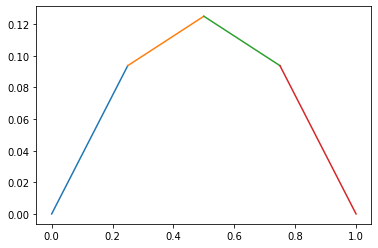

In [7]:
# If f = 1 and sigma = 0, our solution is a parabola: 
# s = -1/2 * x * (x - 1)

# Here ee use the "vectorize" command so that, if x is an array,
# the result of f(x) is not 1 but an array with the same
# shape of x filled with ones

# If we use degree 1 and 4 elements, we get the following
# results:
compute_and_plot_solution(
    degree=1,
    n_of_elements=4,
    f=np.vectorize(lambda x: 1),
    sigma=np.vectorize(lambda x: 0)
)

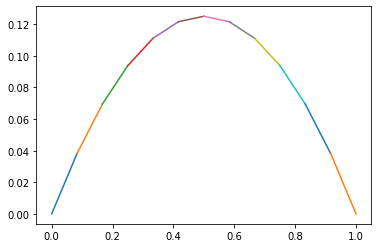

In [8]:
# If we increase the number of elements, the solution seems to resemble
# more to a parabola
compute_and_plot_solution(
    degree=1,
    n_of_elements=12,
    f=np.vectorize(lambda x: 1),
    sigma=np.vectorize(lambda x: 0)
)

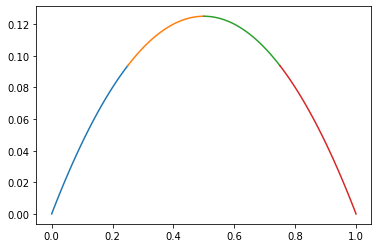

In [9]:
# If instead of using degree 1 we use degree 2, then we get a perfect
# parabola. This is due to the fact that solution IS a polynomial of
# degree 2 and it lives inside out space S_h
compute_and_plot_solution(
    degree=2,
    n_of_elements=4,
    f=np.vectorize(lambda x: 1),
    sigma=np.vectorize(lambda x: 0)
)

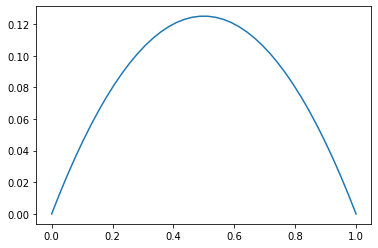

In [10]:
# Indeed, even using only one element, if we use degree 2 we get the
# right solution
compute_and_plot_solution(
    degree=2,
    n_of_elements=1,
    f=np.vectorize(lambda x: 1),
    sigma=np.vectorize(lambda x: 0)
)

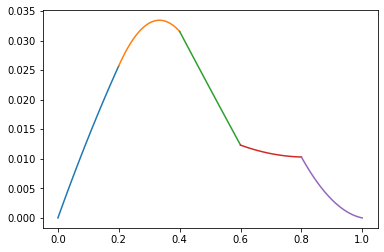

In [11]:
# If we take a more complicated case (for example, we change f)
# then we do not get the correct results even if we use the 
# degree = 2. This means that the correct solution is not a
# polynomial of degree 2
compute_and_plot_solution(
    degree=2,
    n_of_elements=5,
    f=np.vectorize(lambda x: np.sin(4 * np.pi * x * x)),
    sigma=np.vectorize(lambda x: 0)
)

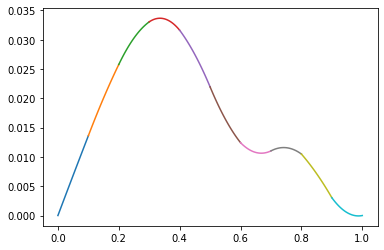

In [12]:
# Again, if we want to get the a better approximation we can increase
# the number of elements
compute_and_plot_solution(
    degree=2,
    n_of_elements=10,
    f=np.vectorize(lambda x: np.sin(4 * np.pi * x * x)),
    sigma=np.vectorize(lambda x: 0)
)

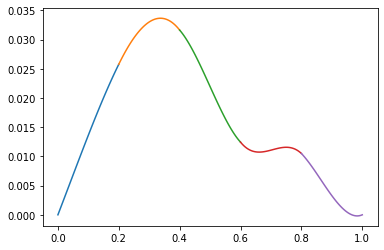

In [13]:
# Or increase the degree
compute_and_plot_solution(
    degree=3,
    n_of_elements=5,
    f=np.vectorize(lambda x: np.sin(4 * np.pi * x * x)),
    sigma=np.vectorize(lambda x: 0)
)

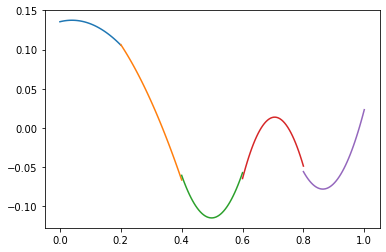

In [14]:
# Was this the right solution or is it just an approximation?
# If we plot the derivative, we can see that it is not continuous
# Because the real solution is derivable an infinite number of
# times, we understand that this is just an approximation
compute_and_plot_solution(
    degree=3,
    n_of_elements=5,
    f=np.vectorize(lambda x: np.sin(4 * np.pi * x * x)),
    sigma=np.vectorize(lambda x: 0),
    der=1
)

In [15]:
import sympy
import sympy.abc

# The method of the manufactured solution is a technique which
# aims to test the convergence of a method by producing some
# parameters for which the right solution is known.
    
# Usually, you start from the solution that you want to have and
# then you choose one of the two parameters accordingly.


def generate_manufactured_solution_from_sigma(s, sigma):
    """
    Given the value of the function sigma, compute a function f
    so that s is the solution of our problem for these sigma and f
    
    We require s to be 0 on the boundaries of our domain, which we
    suppose to be [0, 1]
    
    Args:
        s: the desidered solution as a sympy function
        sigma: the parameter sigma of the problem as a sympy function
    
    Returns:
        The value of the parameter f as a sympy function
    """
    
    # This is the "x" symbol of sympy, the "x" that you use when you
    # write an equation
    x = sympy.abc.x

    # Now I compute the values of s on the boundaries of the domain
    s0 = s.subs(x, 0)
    s1 = s.subs(x, 1)
    
    # If s is not compliant with the boundary conditions, there is no
    # reason to procede and I return an error
    if s0 != 0:
        raise ValueError('s must be 0 at 0, it is {}'.format(s0))
    if s1 != 0:
        raise ValueError('s must be 0 at 0, it is {}'.format(s1))

    # This is the value of f obtained by our original equation
    # diff(s, x, 2) is the second derivative of s respect to x
    return - sympy.diff(s, x, 2) + sigma * s

In [16]:
# For example, if sigma = 1, what is the right f that we have
# to choose so that x^2  - x is a solution for our system?
s = sympy.abc.x * sympy.abc.x - sympy.abc.x
generate_manufactured_solution_from_sigma(s, 1)

x**2 - x - 2

In [17]:
def error_vs_n_of_elements(n_of_elements, degree, s, sigma, f=None):
    """
    Now we want to understand how (and if!) the error decreases as soon
    as we increase the number of the elements inside our domain.
    
    This function computes an extimation of the L^2 error of a manufactured
    solution computed with the finite element method, i.e. we compute the
    error between the exact solution (that we known) and the solution
    produced by the finite element method
    
    Args:
        n_of_elements: a list (or a tuple) of integer numbers. For each number
                       a domain on [0, 1] with that number of elements will be
                       created
        degree: the degree of your finite element method
        s: the correct solution that you want to have for your equation (as a
            sympy function)
        sigma: the parameter sigma of your problem (as a sympy function)
        f: If submitted, the parameter f of your problem (as a sympy function).
           If it is not submitted, it will be computed automatically using the
           function generate_manufactured_solution
    
    Returns:
        A list l of L^2 errors. In particular, the error l[i] is the error
        obtained using a domain with n_of_elements[i] elements
    """
    if degree < 1:
        raise ValueError('Degree must be at least 1')
    
    x = sympy.abc.x
    if f is None:
        f = generate_manufactured_solution_from_sigma(s, sigma)
    
    # We need to make the sympy function evaluable from a numerical point
    # of view for numpy. This is why we use the lambdify function
    s_numpy = np.vectorize(sympy.lambdify(x, s))
    sigma_numpy = np.vectorize(sympy.lambdify(x, sigma))
    f_numpy = sympy.lambdify(x, f)
    
    # These are the number of quadrature points that we are going to use
    # to compute the L2 error on each cell.
    # We are going to integrate element by element; unfortunately,
    # there is a problem. Indeed, if we use this approach, it is possible
    # that, when we use a low number of elements, we also compute the error
    # poorly because we are not using enough points. To mitigate this problem,
    # we will use a lot of points per element. Usually, you do not want to
    # do that, even for estimating the error: indeed, if you add even one
    # quadrature point more than what we did before, the error that you
    # produce with the quadrature rule will decrease faster than the error
    # of your method and, therefore, eventually your extimation of the error
    # will become accurate. But, because I want to be accurate also with few
    # elements, I will use a composite formula that is obtained repeating twice
    # a quadrature formula with two points more than what we used before
    n_q_points = degree + 1 + 2
    q_points, q_weights = leggauss(n_q_points)
    
    q_points_zero_onehalf = q_points / 4. + .25
    q_points_onehalf_one = q_points_zero_onehalf + .5
    q_points = np.concatenate((q_points_zero_onehalf, q_points_onehalf_one))
    
    q_weights = np.concatenate((q_weights, q_weights)) / 4.
    
    # The output of this function! Here we will save the L2 errors that we
    # have computed
    l2_errors = []
    
    for n in n_of_elements:
        # Compute the points that divide the elements; we are still on
        # the domain [0, 1]
        element_split = np.linspace(0., 1., n + 1)[1:-1]

        domain = generate_domain(0, 1., element_split)

        solution, reference_element, dof_map = compute_solution(
            domain,
            degree=degree,
            f=f_numpy,
            sigma=sigma_numpy
        )

        element_evaluators = compute_element_evaluators(
            solution,
            domain,
            dof_map
        )
        
        # Now we compute the L2 error. To do that, we compute the square of
        # the L2 error on each element, and then we sum the result. In
        # l2_error_square we sum the results element by element
        l2_error_square = 0
        for element in domain:
            element_size = element.b - element.a

            # Prepare a quadrature formula for this element
            element_q_points = q_points * element_size + element.a
            element_q_weights = q_weights * element_size
            
            # evaluated the right solution on the quadrature points
            s_values = s_numpy(element_q_points)

            # Evaluated the solution generated by the method
            approx_values = element_evaluators[element](element_q_points)
            
            error = s_values - approx_values
            error_square = error * error
            
            # This is the integral of the square of the error on this element
            l2_error_square += np.sum(error_square * element_q_weights)
        
        l2_error = np.sqrt(l2_error_square)
        l2_errors.append(l2_error)
    
    return l2_errors

In [18]:
# The number of elements we will try our method on
ELEMENT_TESTS = [2 ** i for i in range(9)]
ELEMENT_TESTS

[1, 2, 4, 8, 16, 32, 64, 128, 256]

In [19]:
# For out first test we want s to be something smooth, for example
# sin(x * pi) and the same for sigma, for example 1. In this case,
# the required f is...
x = sympy.abc.x
pi = sympy.pi
sin = sympy.sin
generate_manufactured_solution_from_sigma(sin(x * pi), 1)

sin(pi*x) + pi**2*sin(pi*x)

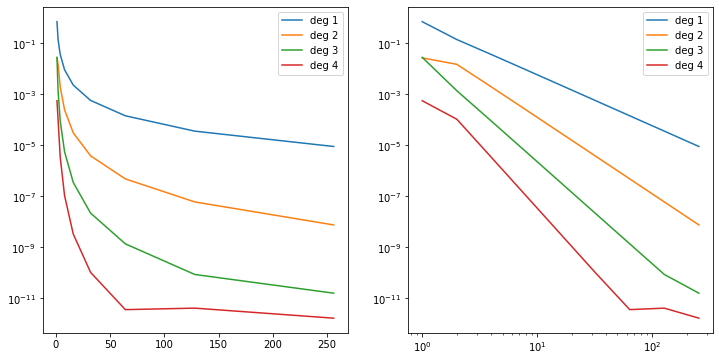

In [20]:
# "errors_by_degree" is a dictionary that associates to each
# degree the vector with the errors that we will plot. In this
# way, we can understand if is convenient to increase the degree
# of the polynomials
errors_by_degree = {}
for degree in range(1, 5):
    errors_by_degree[degree] = error_vs_n_of_elements(
        ELEMENT_TESTS,
        degree=degree,
        s=sin(x * pi),
        sigma=1
    )

# Now we prepare two plots: indeed, the command subplots specifies
# that we want to create a grid of plots with 1 row and 2 columns
# (in other words, two plots, one on the left and one on the right).
plt.subplots(1, 2, figsize=(12, 6))

# Now we work on the plot 1 of our 1x2 grid
plt.subplot(1, 2, 1)
for degree, errors in errors_by_degree.items():
    # For each degree, plot the graphic that relates the number
    # of elements with the L2 error. In this case, we plot the
    # error in log scale, but not the number of the elements
    plt.semilogy(ELEMENT_TESTS, errors, label=f"deg {degree}")
    plt.legend()

# Now we work on the second plot
plt.subplot(1, 2, 2)
for degree, errors in errors_by_degree.items():
    # In this case, we plot using the log scale for both the axis
    plt.loglog(ELEMENT_TESTS, errors, label=f"deg {degree}")
    plt.legend()

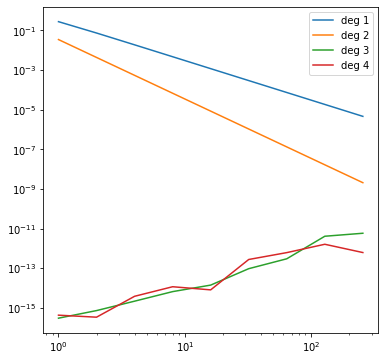

In [21]:
# What we have seen is that increasing the degree not only produces
# better results, but the rate of convergence is improved (indeed,
# the red lines decreases faster than the blue one in the loglog
# plot).
# When we use 2 elements, degree 5 is 1000 times more accurate than
# degree 1; when we use 64 elements, degree 5 is 100.000.000 times
# more accurate

# What happens if our solution is a polynomial of degree 3,
# like, for example, x**3 - x?
errors_by_degree = {}
for degree in range(1, 5):
    errors_by_degree[degree] = error_vs_n_of_elements(
        ELEMENT_TESTS,
        degree=degree,
        s=x**3 - x,
        sigma=1
    )

plt.figure(figsize=(6, 6))
for degree, errors in errors_by_degree.items():
    plt.loglog(ELEMENT_TESTS, errors, label=f"deg {degree}")
_ = plt.legend()

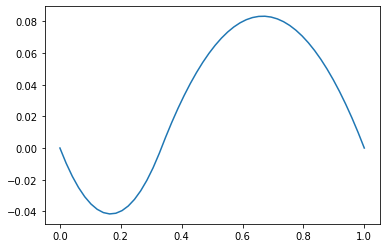

In [22]:
# Can you explain why in the previous plot the degree 3 and degree 4
# behave in such a strange way?

# Let us try with another experiment. This time, we want to build a
# solution that is not regular, In particular it is C^1 but not C^2.
# Indeed, the solution s is obtained from two parabolas. On the 
# interval [0, 1/3] we will consider the function
# 3/2 x^2 - x/2
# that is 0 on 0, and 0 on 1/3. On the interval ]1/3, 1] we choose
# the function
# -3/4 x ** 2 + x - 1/4
# which is again 0 on 1/3 and 0 on 1.
# Let us plot this function

# Here I define some constant that I will use later; because I want them
# to be computed by sympy and not by Python (i.e I want one_quarter to be
# the symbolic fraction 1/4 and not the floating point number 0.25), I
# transform the numbers in elements managed by sympy using the sympify
# function
x = sympy.abc.x
one_quarter = sympy.sympify(1) / sympy.sympify(4)
one_third = sympy.sympify(1) / sympy.sympify(3)

# Here I define s1 and s2
s1 = 3 * x ** 2 / 2 - x / 2
s2 = -3 * x **2 / 4 + x - one_quarter

# s is 0 before 0, s1 from 0 to one third, s2 from 1/3 and 1 and then 0 
s = sympy.Piecewise((0, x < 0), (s1, x < one_third), (s2, x <= 1), (0, True))

# plot s function on x_points
x_points = np.linspace(0, 1, 50)
y_points = np.empty_like(x_points)
for i in range(x_points.shape[0]):
  y_points[i] = s.subs(x, x_points[i])
_ = plt.plot(x_points, y_points)


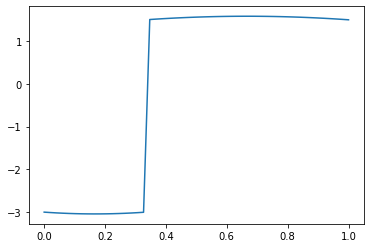

In [23]:
# We can not compute f using the generate_manufactured_solution_from_sigma
# function (because s is not a C^2 function). Therefore, we define f
# as a piecewise function
sigma = sympy.sympify(1)

f1 = - sympy.diff(s1, x, 2) + sigma * s1
f2 = - sympy.diff(s2, x, 2) + sigma * s2
f = sympy.Piecewise((0, x < 0), (f1, x < one_third), (f2, x <= 1), (0, True))

# plot f
x_points = np.linspace(0, 1, 50)
y_points = np.empty_like(x_points)
for i in range(x_points.shape[0]):
  y_points[i] = f.subs(x, x_points[i])
_ = plt.plot(x_points, y_points)

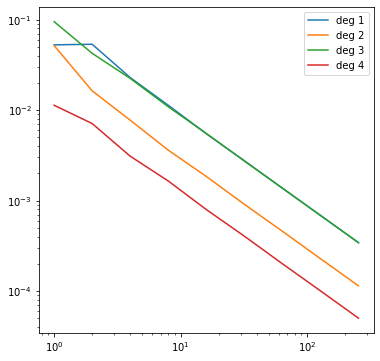

In [24]:
# Ok, now we can try to solve this problem. It is worth
# noting that f is in L2, but it is not continuous (it is
# piecewise constant)
errors_by_degree = {}

for degree in range(1, 5):
    errors_by_degree[degree] = error_vs_n_of_elements(
        ELEMENT_TESTS,
        degree=degree,
        s=s,
        sigma=sigma,
        f=f
    )

plt.figure(figsize=(6, 6))
for degree, errors in errors_by_degree.items():
    plt.loglog(ELEMENT_TESTS, errors, label=f"deg {degree}")
_ = plt.legend()

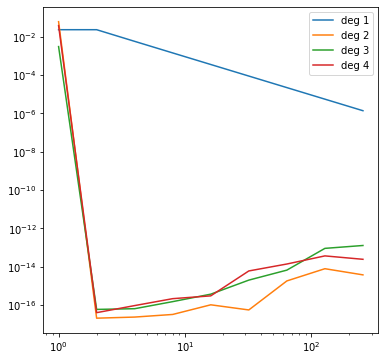

In [25]:
# As you may see, now all the methods have the same order of convergence.
# This is because of the fact that we have lost regularity in our
# solution s
# But, in our previous example, there was just one point that where the
# function was not smooth. What happens if we build another example where
# the non--smooth point is not on 1/3 but is on 1/2? Will it make any
# difference?

errors_by_degree = {}

one_quarter = sympy.sympify(1) / sympy.sympify(4)
one_half = one_quarter * 2

sigma = sympy.sympify(1)

s1 = x**2 / 2 - x / 4
s2 = -x**2 / 2 + 3 * x / 4  - one_quarter
s = sympy.Piecewise((0, x < 0), (s1, x < one_half), (s2, x <= 1), (0, True))

f1 = - sympy.diff(s1, x, 2) + sigma * s1
f2 = - sympy.diff(s2, x, 2) + sigma * s2
f = sympy.Piecewise((0, x < 0), (f1, x < one_half), (f2, x <= 1), (0, True))

for degree in range(1, 5):
    errors_by_degree[degree] = error_vs_n_of_elements(
        ELEMENT_TESTS,
        degree=degree,
        s=s,
        sigma=sigma,
        f=f
    )

plt.figure(figsize=(6, 6))
for degree, errors in errors_by_degree.items():
    plt.loglog(ELEMENT_TESTS, errors, label=f"deg {degree}")
_ = plt.legend()

In [26]:
# Can you explain the previous plot???